# Problem Set 2
* Author: Zixuan Huang 
* Spring 2020

This notebook contrains my solutions to [Problem Set 2](https://www.dropbox.com/s/pgypilows13clgt/ProblemSet2.pdf?dl=0) for the course Topics in Applied Microeconomics, taught by Professor Yujung Hwang at Johns Hopkins University. The problem is basically asking to solve numeric solutions to a consumption optimization problem over finite life periods. The consumer, who is endowed with an intial wealth and allowed to borrow, faces uncertain income shocks which follow an AR(1) process.
<br/><br/>
The results are consistent with intuition: 
* consumers with a low level of wealth has precuationary saving and thus the consumption function is concave. 
* consumers with higher income consume more than those with lower income.

## Model

First, let's import tools that will be used in a minute.

In [93]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon.markov import DiscreteDP
from scipy.stats import norm
from math import sqrt
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import brentq
import time

And set up parameters and functions:
* Method *'Grid'* generates grids for asset.
* Method *'Utility'* is the CRRA utility function with coefficient $\gamma$
* Method *'MU'* is the corresponding marginal utility function
* Method *'Pi'* is the transition matrix generating the following AR(1) process:
> \begin{align}
   \log y_t = \rho \log y_{t-1} + \mu_t \\
   \\
  \end{align}
  where $\mu_t$ follows $N(0,\sigma_\mu^2)$
* Method *'State'* generates the random income streams for individuals

In [197]:
class CakeEating:
    def __init__(self, 
                 T = 40, 
                 r = 0.03, 
                 beta = 0.95, 
                 gamma = 1.5, 
                 a0 = 1, 
                 minCons = 1e-5, 
                 rho = 0.75, 
                 sig = 0.25,
                 N = 5,
                 mu = 0):
        self.T, self.r, self.beta, self.gamma, self.a0, self.minCons, self.rho,self.sig, self.N,self.mu = T, r, beta, gamma, a0, minCons, rho, sig, N, mu    
        
    def Grid(self,y_max,y_min):
        T,r,beta,gamma,a0,minCons = self.T,self.r,self.beta,self.gamma,self.a0,self.minCons
        
        gridMax = np.zeros(T)
        gridMax[0] = a0
        for num in range(T-1):
            gridMax[num+1]=(gridMax[num] + y_max)*(1+r)
        
        gridMin = np.zeros(T)
        gridMin[T-1] = -y_min + minCons
        for t in range(T-1):
            age = T-t-1
            gridMin[age-1] = gridMin[age]/(1+r) - y_min + minCons
        #for num in range(T):
         #   gridMin[num] = - y_min*(1/(1+r)-(1/(1+r))**(T-num+1))/(1-1/(1+r)) 
        
        loggrid = np.zeros((T,20)) 
        grid = np.zeros((T,20))
        for num in range(T):
            span = gridMax[num] - gridMin[num]
            loggrid[num,:] = np.linspace((np.log(1)),(np.log(1+span)),20)
            grid[num,:] = np.exp(loggrid[num,:]) - 1 + gridMin[num]
        
        return(grid)
    
    def Utility(self,c):
        self.gamma =gamma
        return(c**(1-gamma)/(1-gamma))
    
    def MU(self,c):
        self.gamma = gamma
        return(c**(-gamma))
    
    #generate a transition matrix
    def Pi(self):
        sig, rho, N,mu = self.sig,self.rho,self.N,self.mu
        sig_epsilon = sig/sqrt(1-rho**2)
        
        #generate grid points epsilon
        epsilon = []
        epsilon.append(-3*sig_epsilon)
        n = list(range(2,N+1))
        
        for num in n:
            epsilon.append(sig_epsilon*norm.ppf((num-1)/N)+mu)

        epsilon.append(3*sig_epsilon)  #generate epsilon 
        
        #generate z_i
        z=[]
        for i in range(0,N):
            z.append(N*sig_epsilon*(norm.pdf((epsilon[i]-mu)/sig_epsilon)-norm.pdf((epsilon[i+1]-mu)/sig_epsilon)) + mu)
        
        #generate transition matrix
        Pi = np.zeros(shape=(5,5))
        for i in range(0,N):
            for j in range(0,N):
                Pi[i,j] = norm.cdf((epsilon[j+1]-mu*(1-rho)-rho*(epsilon[i+1]))/sig) - norm.cdf((epsilon[j]-mu*(1-rho)-rho*(epsilon[i+1]))/sig)
        
        sum = Pi.sum(axis=1)
        
        #normalize
        for i in range(0,N):
            for j in range(0,N):
                Pi[i,j] = Pi[i,j]/sum[i]  
        
        
        return Pi, z
    
    #generate states by the transition matrix, return to a vector of states for T periods  
    def State(self):
        Pi,T,N = self.Pi, self.T,self.N
        np.random.seed(123)
        state=np.zeros(T)
        state[0] = np.random.choice(range(5), 1, replace = True, p=[0.2,0.2,0.2,0.2,0.2])
        for t in range(1,T):
            p=[]
            for j in range(0,N):
                p.append(Pi[int(state[t-1]),j])  #int is to convert the float to integer
                
            state[t] = np.random.choice(range(5),1,replace=True,p=p)
        return state
    

To solve the model, first extract variables and functions which will be used shortly from the model specification.

In [207]:
model = CakeEating()
Pi,z = model.Pi()
y = np.exp(z)
a_grid = model.Grid(max(y),min(y))
MU = model.MU

In [208]:
T = model.T
N = model.N
r,beta, gamma = model.r, model.beta, model.gamma

Construct consumption and value matrix. Both of them are 3-dimensional: the first dimension is time, the second corresponds to asset grids and the last dimension is associated with income states. Here we use five income states to simulate the random process. 

In [200]:
c_matrix = []
for j in range(5):
    c_matrix.append(a_grid[T-1]+y[j])    

In [201]:
v_matrix = []
#length is 5, each array has 20 elements. this is for the last period
for i in range(5):
    v_matrix.append(model.Utility(c_matrix[i]))

In [202]:
#generate c and v as three dimensional array, the first dimension is time, the second dimension is a, and the last dimension is income.
c = np.zeros((T,20,5))
v = np.zeros((T,20,5))
for j in range(5):
    for i in range(20):
        c[T-1,i,j] = c_matrix[j][i] 
        v[T-1,i,j] = v_matrix[j][i]

Then, write the function which will be used soon -- value function and Euler euqation:
* **ValueFun** represents the right hand side of Bellman equation, which needs to be maximized.
* **c_star** is the function which searches for the optimal consumption through maximizing the value function.
* **Euler** is the Euler function, which should be equal to zero at the optimal point. 

In [203]:
def ValueFun(c, a, index):
    #Pi,z = model.Pi()
    w = Pi[index]
    if c < 1e-5:
        value = -1e10
    else:
        value1 = np.zeros(N)
        for i in range(N):
            value1[i] = v_inter(y[i],(a+y[index]-c)*(1+r))
        value = model.Utility(c) + beta*np.average(value1,weights = w)
    return value

In [204]:
# find optimial consumption
def c_star(a, index, lbar, ubar):
    #lbar = 1e-10
    #ubar = a + y[index] + np.min(y)*(1/(1+r)-(1/(1+r)**(T-t)))/(1-1/(1+r))  #upper bound is to spend all money today the individaul has and borrow what he can return back if he always receives low income
    #print(lbar,ubar)
    
    result = minimize_scalar(lambda c: -ValueFun(c, a, index), bounds=(lbar,ubar), method = 'bounded')
    c_star = result.x
    v_star = -result.fun
    #print(c_star)
    #v_star = -v_star
    return c_star, v_star

In [111]:
def Euler(a0,index,a1):
    ConsumptionToday = a0 + y[index] - a1/(1+r)
    w = Pi[index]
    data = np.zeros(5)
    for i in range(5):
        data[i] = MU2(y[i],a1)
    #data = np.concatenate((MU2(y[0],a1),MU2(y[1],a1),MU2(y[2],a1),MU2(y[3],a1),MU2(y[4],a1)),axis = None)
    ExpectedMU = np.average(data, weights = w)
    Euler = MU(ConsumptionToday) - (1+r)*beta*ExpectedMU
    return Euler

# Model Solving
I first solve consumption using **Euler**.

In [112]:
c_Euler = np.zeros((T,20,5))
c_Euler[T-1] = c[T-1]
optimal_a = np.zeros((T,20,5))
for t in range(T-1):
    lb = np.min(a_grid[T-t-1])
    yy, aa = np.meshgrid(y, a_grid[T-t-1])
    MU2 = interp2d(y,a_grid[T-t-1],MU(c_Euler[T-t-1]))
    for i in range(20):
        for j in range(5):
            ub = (1+r)*(a_grid[T-t-2,i]+y[j]-1e-5) #+max(y)*(1-(1/(1+r))**(T-t))/(1-1/(1+r))
            diff = ub - lb
            if diff < 1e-5 or Euler(a_grid[T-t-2,i],j,lb) > 0:
                optimal_a[T-t-1,i,j] = lb
                c_Euler[T-t-2,i,j] = a_grid[T-t-2,i] + y[j] - optimal_a[T-t-1,i,j]/(1+r)
            else:
                optimal_a[T-t-1,i,j] = optimize.brentq(lambda a1: Euler(a_grid[T-t-2,i],j,a1),lb,ub)
                c_Euler[T-t-2,i,j] = a_grid[T-t-2,i] + y[j] - optimal_a[T-t-1,i,j]/(1+r)
                if c_Euler[T-t-2,i,j]<0:
                    print(t, i, j)
                    print(lb, ub*0.99,optimal_a[T-t-1,i,j])
                    raise ValueError('your c is negative!!!!')

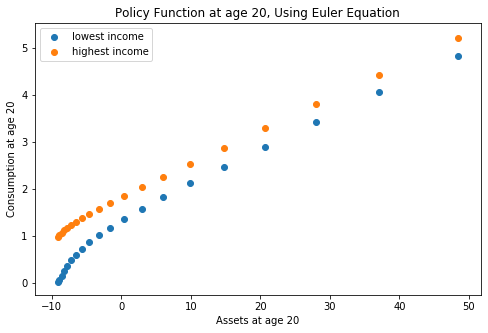

In [323]:
figure, axes = plt.subplots(figsize=(8,5)) 
axes.scatter(a_grid[20],c_Euler[20,:,0], label='lowest income')
axes.scatter(a_grid[20],c_Euler[20,:,4], label='highest income')
axes.set_xlabel('Assets at age 20')
axes.set_ylabel('Consumption at age 20')
axes.set_title('Policy Function at age 20, Using Euler Equation')
axes.legend()
figure.savefig('Euler no trans.jpg')


Then let's compute policy function by **maximization of value function**. The lower bound for consumption is $10^{-5}$, while the upper bound for consumption is such that the consumer will for sure not default in the future. 

In [205]:
for t in range(T-1):
    age = T-t-1
    grid = a_grid[age]
    v_array = v[age]
    yy,gg = np.meshgrid(y,grid)
    v_inter = interp2d(y,grid,v_array)
    for i in range(20):
        for j in range(5):
            lbar = 1e-10
            ubar = a_grid[age-1][i] + y[j] - np.min(a_grid[age])/(1+r)
            #ubar = a_grid[age-1][i] + y[j] + np.min(y)*(1/(1+r)-(1/(1+r)**(T-age+1)))/(1-1/(1+r)) 
            if ubar < lbar:
                c[age-1,i,j], v[age-1,i,j] = ubar, 1e-10
            else:
                a = a_grid[age-1][i]
                c[age-1,i,j],v[age-1,i,j] = c_star(a, j, lbar, ubar)   

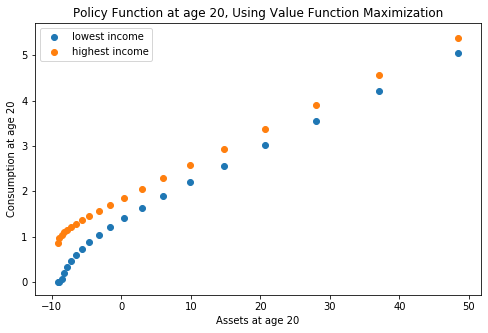

In [322]:
figure, axes = plt.subplots(figsize=(8,5)) 
axes.scatter(a_grid[20],c[20,:,0], label='lowest income')
axes.scatter(a_grid[20],c[20,:,4], label='highest income')
axes.set_xlabel('Assets at age 20')
axes.set_ylabel('Consumption at age 20')
axes.set_title('Policy Function at age 20, Using Value Function Maximization')
axes.legend()
figure.savefig('value func.jpg')

Next, solve the model using interpolation of **marginal utility with linear transformation**.

In [ ]:
def Euler_linear(a0,index,a1):
    ConsumptionToday = a0 + y[index] - a1/(1+r)
    w = Pi[index]
    data = np.zeros(5)
    for i in range(5):
        data[i] = (MU2_linear(y[i],a1))**(-gamma)
    #data = np.concatenate((MU2(y[0],a1),MU2(y[1],a1),MU2(y[2],a1),MU2(y[3],a1),MU2(y[4],a1)),axis = None)
    ExpectedMU = np.average(data, weights = w)
    Euler = MU(ConsumptionToday) - (1+r)*beta*ExpectedMU
    return Euler

In [ ]:
c_Euler_linear = np.zeros((T,20,5))
c_Euler_linear[T-1] = c[T-1]
optimal_a_linear = np.zeros((T,20,5))
gamma = model.gamma
for t in range(T-1):
    lb = np.min(a_grid[T-t-1])
    yy, aa = np.meshgrid(y, a_grid[T-t-1])
    MU2_linear = interp2d(y,a_grid[T-t-1],(MU(c_Euler[T-t-1]))**(-1/gamma))
    for i in range(20):
        for j in range(5):
            ub = (1+r)*(a_grid[T-t-2,i]+y[j]-1e-5) #+max(y)*(1-(1/(1+r))**(T-t))/(1-1/(1+r))
            diff = ub - lb
            if diff < 1e-5 or Euler_linear(a_grid[T-t-2,i],j,lb) > 0:  # if constrained
                optimal_a_linear[T-t-1,i,j] = lb
                c_Euler_linear[T-t-2,i,j] = a_grid[T-t-2,i] + y[j] - optimal_a_linear[T-t-1,i,j]/(1+r)
            else:
                optimal_a_linear[T-t-1,i,j] = optimize.brentq(lambda a1: Euler_linear(a_grid[T-t-2,i],j,a1),lb,ub)
                c_Euler_linear[T-t-2,i,j] = a_grid[T-t-2,i] + y[j] - optimal_a_linear[T-t-1,i,j]/(1+r)
                if c_Euler[T-t-2,i,j]<0:
                    print(t, i, j)
                    print(lb, ub,optimal_a_linear[T-t-1,i,j])
                    raise ValueError('your c is negative!!!!')

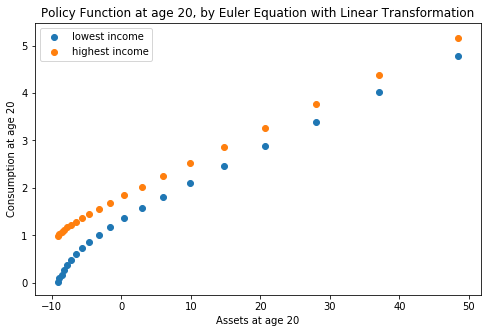

In [319]:
figure, axes = plt.subplots(figsize=(8,5)) 
axes.scatter(a_grid[20],c_Euler_linear[20,:,0], label='lowest income')
axes.scatter(a_grid[20],c_Euler_linear[20,:,4], label='highest income')
axes.set_xlabel('Assets at age 20')
axes.set_ylabel('Consumption at age 20')
axes.set_title('Policy Function at age 20, by Euler Equation with Linear Transformation')
axes.legend()
figure.savefig('Euler.jpg')

# Simulation
Then I will simulate the consumption decision for 100 individuals and plot the mean asset and mean consumption over the life-cycle.

First, generate income profiles for individuals

In [ ]:
np.random.seed(20200202)
num_ind = 100
state = np.zeros((num_ind,T))

for i in range(num_ind):
    state[i,0] = np.random.choice(range(N), 1, replace = True, p=[0.2,0.2,0.2,0.2,0.2])
    for t in range(1,T):
        p=[]
        for j in range(N):
            p.append(Pi[int(state[i,t-1]),j])  #int is to convert the float to integer
            
        state[i,t] = np.random.choice(range(N),1,replace=True,p=p)

In [220]:
num_ind = 100
cons = np.zeros([num_ind,T])
a1 = np.zeros([num_ind,T])
y_t = np.zeros([num_ind,T])
a0 = model.a0

for t in range(T):
    a = a_grid[t]
    yy, aa = np.meshgrid(y,a)
    consumption = interp2d(y,a,c_Euler_linear[t])   
    for i in range(num_ind):
        index = int(state[i,t])
        y_t[i,t] = y[index]
        if t == 0:
            cons[i,t] = consumption(y_t[i,t],a0)
            a1[i,t] = (a0 + y_t[i,t] - cons[i,t])*(1+r)
        else:
            cons[i,t] = consumption(y_t[i,t],a1[i,t-1])
            a1[i,t] = (a1[i,t-1] + y_t[i,t]- cons[i,t])*(1+r)

In [221]:
c_mean = np.zeros(T)
a_mean = np.zeros(T)
for t in range(T):
    c_mean[t] = np.average(cons[:,t])
    a_mean[t] = np.average(a1[:,t])

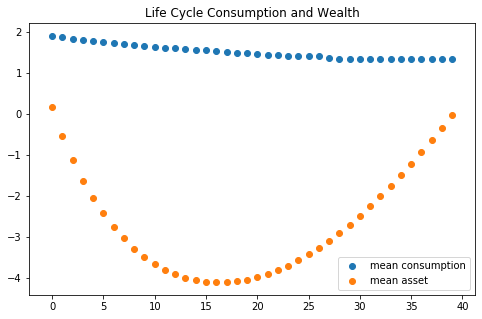

In [327]:
figure, axes = plt.subplots(figsize=(8,5)) 
axes.scatter(range(T),c_mean, label='mean consumption')
axes.scatter(range(T),a_mean, label='mean asset')
axes.set_title('Life Cycle Consumption and Wealth')
axes.legend()
figure.savefig('LifeCycle.jpg')

# Comments
* **Over time**: 
 * Consumption smoothness: since households are allowed to borrow, they would like to smooth consumption due to impatience. 
 * Saving: in order to smooth consumption, households borrow at the early stage of their life, and accumulate wealth when they are getting old. 
 * Concavity of consumption function: due to precautionary motive, marginal propensity to consume is larger when they are poor than when they are rich. This provides policy implications for government when redistributing wealth across different groups of people. 
* **Over income shocks**:
 * Level of income: people with the same wealth level behave differently when receiving different incomes. 
 * Expectation: the fact that people who earns more consume more is not just because they receive more, but also because they expect to earn more in the future due to the AR process. That is, in the world of uncertainty, expectation does play a significant role in influencing behaviors and decsion making.
* **Representative and heterogenous agent**:
 * Heterogeneity: the model is heterogenous in the sense that households receive idiosyncratic income shocks and thus have different wealth level. 
 * Representativity: however, all individuals have the same homothetic preference(homogenous utility function, and they share the same beta), so the economy as a whole behaves like a represetative agent. 

(Try Endogenous grid.....draft)

In [297]:
# this cell is just for the last period grid......
def EndoGrid(y_max,y_min,num_grid):
        T,r,beta,gamma,a0,minCons = model.T,model.r,model.beta,model.gamma,model.a0,model.minCons
        
        gridMax = np.zeros(T)
        gridMax[0] = a0
        for num in range(T-1):
            gridMax[num+1]=(gridMax[num] + y_max)*(1+r)
        
        gridMin = np.zeros(T)
        gridMin[T-1] = -y_min + minCons
        for t in range(T-1):
            age = T-t-1
            gridMin[age-1] = gridMin[age]/(1+r) - y_min + minCons
        #for num in range(T):
         #   gridMin[num] = - y_min*(1/(1+r)-(1/(1+r))**(T-num+1))/(1-1/(1+r)) 
        
        loggrid = np.zeros((T,num_grid)) 
        grid = np.zeros((T,num_grid))
        for num in range(T):
            span = gridMax[num] - gridMin[num]
            loggrid[num,:] = np.linspace((np.log(1)),(np.log(1+span)),num_grid)
            grid[num,:] = np.exp(loggrid[num,:]) - 1 + gridMin[num]
        
        return(grid)

In [283]:
num_grid = 250
a_EndoGrid = EndoGrid(np.max(y),np.min(y),num_grid)

In [285]:

Marginal_Utility = np.zeros([T,num_grid,N])
con = np.zeros([T,num_grid,N])
asset = np.zeros([T,num_grid,N])
for j in range(N):
    asset[T-1,:,j] = a_EndoGrid[T-1]
for i in range(num_grid):
    for j in range(N):
        Marginal_Utility[T-1,i,j] = MU(a_EndoGrid[T-1,i]+y[j])
        con[T-1,i,j] = (Marginal_Utility[T-1,i,j])**(-1/gamma)

In [286]:
for t in range(T):
    age = T-t-2
    for i in range(num_grid):
        for j in range(N):
            w = Pi[j]
            data = Marginal_Utility[age+1,i,:]
            Marginal_Utility[age,i,j] = (1+r)*beta*np.average(data,weights=w)
            con[age,i,j] = Marginal_Utility[age,i,j]**(-1/gamma)
            asset[age,i,j] = asset[age+1,i,j]/(1+r)+con[age,i,j]-y[j]
            

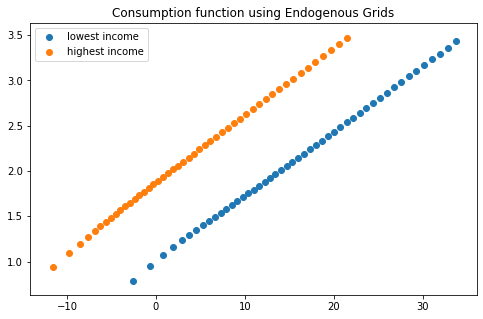

In [295]:
figure, axes = plt.subplots(figsize=(8,5)) 
axes.scatter(asset[20,2:50,0],con[20,2:50,0],label='lowest income')
axes.scatter(asset[20,2:50,4],con[20,2:50,4],label='highest income')
axes.set_title('Consumption function using Endogenous Grids')
axes.legend()

Problem is: grids get sparse when assetl level is small, so the concave part of the consumption function is hidden. May need more work.